# Workflow for pre-processing the data to creatine a working dataset that will be used for model fine-tuning.

In [1]:
#install required package
!pip install spacy 

In [2]:
#import needed libraries
import re, json, os, itertools
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy.training import offsets_to_biluo_tags
from spacy.util import filter_spans

## File Handling

In [3]:
#Path to each individual contract txt file
TC_PATH = "CUAD_v1/full_contract_txt/"

#Path to folder containing all the CUAD_v1 data and files
MASTER_PATH = "CUAD_v1/"

#CSV file containing the extracted clauses
MASTER_CLAUSES = 'master_clauses.csv'

#JSON file for finalized tokenized data
DATA_FILE = 'cuad-v1-annotated.json'

#feature labels
FEATURE_CLASS_LABELS = "feature_class_labels.json"

## Data Pre-processing

In [4]:
#iterate through all .txt files and create a dataframe with filenames
text_files = []
for (dirpath, dirnames, filenames) in os.walk(TC_PATH):
    text_files.extend(filenames)

#create dataframe
tf_df = pd.DataFrame(data = text_files, columns = ['Text Files'])
#sort files alphanumerically
tf_df.sort_values('Text Files', axis=0, inplace=True, ignore_index=True) 

In [5]:
#Read master clauses CSV into a dataframe, sort by filename to match text file dataframe
mc_df = pd.read_csv(MASTER_PATH+MASTER_CLAUSES)
#Cut out relevant info
mc_df_cut = mc_df[['Filename',
                   'Document Name',
                   'Document Name-Answer',
                   'Parties',
                   'Parties-Answer',
                   'Agreement Date',
                   'Agreement Date-Answer',
                   'Effective Date',
                   'Effective Date-Answer']].copy()

#Sort dataframe by filename
mc_df_cut.sort_values('Filename', axis=0, inplace=True, ignore_index=True) 
#Bring in the list of the .txt filenames
mc_df_cut.insert(loc=1,column='Text Files', value=tf_df['Text Files'])
#Create an indexed list of the names of the files
file_list = [(index, row['Text Files']) for index, row in mc_df_cut.iterrows()]
#Display initial dataframe info
mc_df_cut.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Filename               510 non-null    object
 1   Text Files             510 non-null    object
 2   Document Name          510 non-null    object
 3   Document Name-Answer   510 non-null    object
 4   Parties                510 non-null    object
 5   Parties-Answer         509 non-null    object
 6   Agreement Date         510 non-null    object
 7   Agreement Date-Answer  465 non-null    object
 8   Effective Date         510 non-null    object
 9   Effective Date-Answer  359 non-null    object
dtypes: object(10)
memory usage: 40.0+ KB


In [6]:
#function to pre-process text and make all files have the same formatting 
def pre_process(text):
    #replacement for "\n"
    text = text.replace("\n", " ")     
    
    #replacement for "\xa0"
    text = text.replace("\xa0", " ")  
    
    #replacement for "\x0c"
    text = text.replace("\x0c", " ")
    
    #remove of multiple dots
    regex = "\ \.\ "
    subst = "."
    text = re.sub(regex, subst, text, 0)
    
    #remove underscores
    regex = "_"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    #remove multiple dashes
    regex = "--+"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    #remove multiple stars
    regex = "\*+"
    subst = "*"
    text = re.sub(regex, subst, text, 0)
    
    #remove multiple whitespace
    regex = "\ +"
    subst = " "
    text = re.sub(regex, subst, text, 0)
    
    #remove whitespace
    text = text.strip()
    
    return text

#function that reads each file from a list, cleans the text, and returns all agreements in a list
def text_data(file_list, max_len=3000):
    text_list = []
    for index, filename in tqdm(file_list):
        agreement = open(TC_PATH+filename, "r", encoding="utf8")
        text = agreement.read()
        text = pre_process(text)
        text = text[:max_len]
        len_text = len(text)
        text_list.append([index,
                  filename,
                  text,
                  len_text])
        
    return text_list

In [7]:
#clean text and create dataframe with the text of each document
data = text_data(file_list, max_len=1000)
columns = ['ID', 'Documents', 'Text', 'Length_Of_Text']
text_df = pd.DataFrame(data=data, columns=columns)

#add two columns to a copy of main dataframe
mc_df_wk = mc_df_cut.copy()
mc_df_wk = mc_df_wk.join(text_df[['Text', 'Length_Of_Text']])

#ensure document name, parties, agreement date, and effective date are list objects
mc_df_wk["Document Name"] = mc_df_wk["Document Name"].apply(eval)
mc_df_wk["Parties"] = mc_df_wk["Parties"].apply(eval)
mc_df_wk["Agreement Date"] = mc_df_wk["Agreement Date"].apply(eval)
mc_df_wk["Effective Date"] = mc_df_wk["Effective Date"].apply(eval)

#remove document name references with > than one entry
mc_df_wk['Doc_N_Length'] = mc_df_wk['Document Name'].str.len()
mc_df_mul = mc_df_wk[mc_df_wk.Doc_N_Length > 1]
mc_df_wk.drop(mc_df_mul.index, inplace=True)

#examine df
mc_df_wk.head(5)

100%|██████████| 510/510 [00:06<00:00, 74.90it/s]


,Filename,Text Files,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Text,Length_Of_Text,Doc_N_Length
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,[CO-BRANDING AND ADVERTISING AGREEMENT],CO-BRANDING AND ADVERTISING AGREEMENT,"[2THEMART.COM, INC., 2TheMart, i-Escrow, I-ESC...","I-ESCROW, INC. (""i-Escrow"" ); 2THEMART.COM, I...","[June 21, 1999]",6/21/99,"[June 21, 1999]",6/21/99,CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-...,1000,1
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,[Services Agreement],Services Agreement,"[""Provider"", TELCOSTAR PTE, LTD., Each of the ...","[ * * * ] (""Provider""); TELCOSTAR PTE, LTD.; A...","[October 1, 2019]",10/1/19,"[November 1, 2019]",11/1/19,EXHIBIT 4.25 INFORMATION IN THIS EXHIBIT IDENT...,1000,1
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,[JOINT VENTURE AGREEMENT],JOINT VENTURE AGREEMENT,"[Pivotal Self Service Tech, Inc., (the ""Partie...","Collectible Concepts Group, Inc. (""CCGI""); Piv...",[],NaN,[The Joint Venture shall commence on the 1st o...,3/1/03,EXHIBIT 10.13 JOINT VENTURE AGREEMENT Collecti...,1000,1
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGR...,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGR...,[Multiple LINAC and Multi-Modality Distributor...,Multiple LINAC and Multi-Modality Distributor ...,"[Siemens, Accuray, ACCURAY INCORPORATED, SIEME...","ACCURAY INCORPORATED, (""Accuray""); SIEMENS AKT...","[June 8, 2010]",6/8/10,"[June 8, 2010]",6/8/10,Exhibit 10.31 PURSUANT TO 17 C.F.R. § 240.24B-...,1000,1
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT A...,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT A...,[ENDORSEMENT AGREEMENT],ENDORSEMENT AGREEMENT,"[ADAMS GOLF, LTD., TOM WATSON, ADAMS GOLF, CON...","TOM WATSON (""CONSULTANT""); ADAMS GOLF, LTD. (""...","[January 13, 2005]",1/13/05,[The Term of this Agreement shall be for a per...,9/1/04,REDACTED COPY CONFIDENTIAL TREATMENT REQUESTED...,1000,1


In [8]:
# Check for null values
mc_df_wk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 509
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Filename               499 non-null    object
 1   Text Files             499 non-null    object
 2   Document Name          499 non-null    object
 3   Document Name-Answer   499 non-null    object
 4   Parties                499 non-null    object
 5   Parties-Answer         498 non-null    object
 6   Agreement Date         499 non-null    object
 7   Agreement Date-Answer  458 non-null    object
 8   Effective Date         499 non-null    object
 9   Effective Date-Answer  355 non-null    object
 10  Text                   499 non-null    object
 11  Length_Of_Text         499 non-null    int64 
 12  Doc_N_Length           499 non-null    int64 
dtypes: int64(2), object(11)
memory usage: 54.6+ KB


In [70]:
#Agreement date and effective date are important labels. Drop agreements without these dates.

#check for and remove null Agreement date 
mc_df_null_agreeement = mc_df_wk[mc_df_wk["Agreement Date-Answer"].isnull()]
mc_df_wk = mc_df_wk.dropna(subset=['Agreement Date-Answer'])

#check for and remove null Effective date
mc_df_null_effective = mc_df_wk[mc_df_wk["Effective Date-Answer"].isnull()]
mc_df_wk = mc_df_wk.dropna(subset=['Effective Date-Answer'])
mc_df_wk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343 entries, 0 to 509
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Filename               343 non-null    object
 1   Text Files             343 non-null    object
 2   Document Name          343 non-null    object
 3   Document Name-Answer   343 non-null    object
 4   Parties                343 non-null    object
 5   Parties-Answer         343 non-null    object
 6   Agreement Date         343 non-null    object
 7   Agreement Date-Answer  343 non-null    object
 8   Effective Date         343 non-null    object
 9   Effective Date-Answer  343 non-null    object
 10  Text                   343 non-null    object
 11  Length_Of_Text         343 non-null    int64 
 12  Doc_N_Length           343 non-null    int64 
dtypes: int64(2), object(11)
memory usage: 37.5+ KB


In [110]:
#extract legal entity from party definition
def remove_party_overlaps(labels):
    labels.sort()
    temp = []
    for i in range(len(labels)-1):
        l1 = labels[i]
        l2 = labels[i+1]
        if l1[0] == l2[0]:
            len1 = l1[1] - l1[0]
            len2 = l2[1] - l2[0]
            if len1 > len2:
                temp.append(l1)
                continue
            else:
                temp.append(l2)
                continue
        else:
            temp.append(labels[i])
    new_labels = list(temp for temp,_ in itertools.groupby(temp))
    
    return new_labels

In [147]:
#for each label, find the label in text, ensure label is pre-processed same as text
#if labels don't match, do not add to working dataframe

columns = ['id', 'text', 'labels']
df = pd.DataFrame(columns=columns)
clean_text = True
for index, row in tqdm(mc_df_wk.iterrows()):
    labels = list()
    ids = index
    text = row['Text']
    
    #PARTIES
    parties = row['Parties']
    for party in parties:
        if clean_text:
            party = pre_process(party)
        matches = re.finditer(re.escape(party.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'PARTY'])
            
    labels = remove_party_overlaps(labels)
    
    #DOC_NAME
    doc_names = row['Document Name']
    for name in doc_names:
        if clean_text:
            name = pre_process(name)
        matches = re.finditer(re.escape(name.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'DOC_NAME'])
    
    #EFF_DATE
    eff_date = row['Effective Date']
    for date in eff_date:
        if clean_text:
            date = pre_process(date)
        matches = re.finditer(re.escape(date.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'EFF_DATE'])
    
    #AGMT_DATE
    agmt_date = row['Agreement Date']
    for date in agmt_date:
        if clean_text:
            date = pre_process(date)
        matches = re.finditer(re.escape(date.lower()), text.lower())
        for m in matches:
            s = m.start()
            e = m.end()
            labels.append([s, e, 'AGMT_DATE'])
    
    #add to df
    flat_list = [item for sublist in labels for item in sublist]
    if 'DOC_NAME' in flat_list and 'PARTY' in flat_list and ('AGMT_DATE' in flat_list or 'EFF_DATE' in flat_list):
        df.loc[len(df)]=[ids,text,labels]
df.head()

343it [00:00, 547.90it/s]


,id,text,labels
0,0,CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-...,"[[165, 179, PARTY], [286, 294, PARTY], [302, 3..."
1,1,EXHIBIT 4.25 INFORMATION IN THIS EXHIBIT IDENT...,"[[421, 431, PARTY], [438, 457, PARTY], [524, 5..."
2,3,Exhibit 10.31 PURSUANT TO 17 C.F.R. § 240.24B-...,"[[278, 298, PARTY], [461, 481, PARTY], [604, 6..."
3,4,REDACTED COPY CONFIDENTIAL TREATMENT REQUESTED...,"[[260, 270, PARTY], [301, 311, PARTY], [318, 3..."
4,5,Exhibit 10.11 *Certain portions of this exhibi...,"[[465, 517, PARTY], [601, 612, PARTY], [686, 7..."


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 288
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      289 non-null    int64 
 1   text    289 non-null    object
 2   labels  289 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.0+ KB


## Tokenization

In [149]:
#some samples were not annotated as they were not suitable samples
#eliminate unannotated samples
df_cut = df[df['labels'].map(lambda d: len(d)) > 0].copy()
#tokenize each agreement prior to bringing into the transformer model
#create tokens using spaCy
nlp = English()
df_cut['tokens'] = df_cut['text'].apply(lambda x: nlp(x))
df_cut.head()

,id,text,labels,tokens
0,0,CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-...,"[[165, 179, PARTY], [286, 294, PARTY], [302, 3...","(CO, -, BRANDING, AND, ADVERTISING, AGREEMENT,..."
1,1,EXHIBIT 4.25 INFORMATION IN THIS EXHIBIT IDENT...,"[[421, 431, PARTY], [438, 457, PARTY], [524, 5...","(EXHIBIT, 4.25, INFORMATION, IN, THIS, EXHIBIT..."
2,3,Exhibit 10.31 PURSUANT TO 17 C.F.R. § 240.24B-...,"[[278, 298, PARTY], [461, 481, PARTY], [604, 6...","(Exhibit, 10.31, PURSUANT, TO, 17, C.F.R., §, ..."
3,4,REDACTED COPY CONFIDENTIAL TREATMENT REQUESTED...,"[[260, 270, PARTY], [301, 311, PARTY], [318, 3...","(REDACTED, COPY, CONFIDENTIAL, TREATMENT, REQU..."
4,5,Exhibit 10.11 *Certain portions of this exhibi...,"[[465, 517, PARTY], [601, 612, PARTY], [686, 7...","(Exhibit, 10.11, *, Certain, portions, of, thi..."


In [150]:
#review example of the text indices and accompanying labels
row = df_cut.iloc[4]
doc = row['tokens']
for start, end, label in row['labels']:
    print(start, end, label)
print (row['text'])

465 517 PARTY
601 612 PARTY
686 701 PARTY
788 799 PARTY
807 826 PARTY
907 926 PARTY
930 941 PARTY
283 311 DOC_NAME
386 413 EFF_DATE
386 413 AGMT_DATE
Exhibit 10.11 *Certain portions of this exhibit have been omitted based on a request for confidential treatment pursuant to Rule 24b-2 under the Securities Exchange Act of 1934, as amended. The omitted portions have been filed separately with the Securities and Exchange Commission. STRATEGIC ALLIANCE AGREEMENT This Strategic Collaboration Agreement ("Agreement"), effective as of the 23rd day of September, 2016 ("Effective Date"), is entered into by and between The University of Texas M. D. Anderson Cancer Center, with a place of business located at 1515 Holcombe Blvd., Houston, TX 77030, USA ("MD Anderson"), a member institution of The University of Texas System ("System") and Adaptimmune LLC, with a place of business located at 2001 Market Street, Philadelphia, PA 1903, USA ("Adaptimmune"); and Adaptimmune Limited, with a place of busine

The total number of labels in the dataset is: 5522


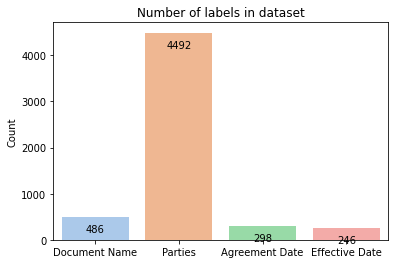

In [151]:
#count and visualise the amount of labels

DOC_NAME_COUNT = 0
PARTIES_COUNT = 0
AGMT_DATE_COUNT = 0
EFF_DATE_COUNT = 0
for index, row in df_cut.iterrows():
    for l in row['labels']:
        if l[2] == "DOC_NAME":
            DOC_NAME_COUNT += 1
        if l[2] == "PARTY":
            PARTIES_COUNT += 1
        if l[2] == "AGMT_DATE":
            AGMT_DATE_COUNT += 1
        if l[2] == "EFF_DATE":
            EFF_DATE_COUNT += 1

#create DataFrame for bar plot
data=pd.DataFrame.from_dict({"Document Name":[DOC_NAME_COUNT],
                             "Parties":[PARTIES_COUNT],
                             "Agreement Date":[AGMT_DATE_COUNT],
                             "Effective Date":[EFF_DATE_COUNT]})

#use Seaborn for bar plot
splot = sns.barplot(palette="pastel", data=data)
splot.set(title='Number of labels in dataset', ylabel='Count')

#annotate the bars with the count of labels
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.,p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
#show plot
plt.show

print("The total number of labels in the dataset is:", DOC_NAME_COUNT+PARTIES_COUNT+AGMT_DATE_COUNT+EFF_DATE_COUNT)

In [152]:
#each word must be seperated for the transformer  model using the IOB format
#create tags using token.ent_iob_ and add to DataFrame
tags_list_iob = []
for index, row in df_cut.iterrows():
    doc = row['tokens']
    ents=[]
    for start, end, label in row['labels']:
        if doc.char_span(start, end, label) != None:
            ent = doc.char_span(start, end, label)
            ents.append(ent)
        elif doc.char_span(start, end+1, label) != None:
            ent = doc.char_span(start, end+1, label)
            ents.append(ent)
        elif doc.char_span(start+1, end, label) != None:
            ent = doc.char_span(start+1, end, label)
            ents.append(ent)
        elif doc.char_span(start, end-1, label) != None:
            ent = doc.char_span(start, end-1, label)
            ents.append(ent)
        elif doc.char_span(start-1, end, label) != None:
            ent = doc.char_span(start-1, end, label)
            ents.append(ent)
    filtered = filter_spans(ents)
    doc.ents = filtered
    iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ != "O" else "O" for t in doc]
    tags_list_iob.append(iob_tags)
df_cut['tags'] = tags_list_iob

In [153]:
#ensure data is non-null
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 288
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      289 non-null    int64 
 1   text    289 non-null    object
 2   labels  289 non-null    object
 3   tokens  289 non-null    object
 4   tags    289 non-null    object
dtypes: int64(1), object(4)
memory usage: 13.5+ KB


In [154]:
#generate list of IOB feature class labels from tags
all_tags = list(itertools.chain.from_iterable(tags_list_iob))

def unique(list1):
    #insert list to the set
    list_set = set(list1)
    #convert set to the list
    unique_list = (list(list_set))
    unique_list.sort()
    return unique_list

feature_class_labels = unique(all_tags)
print(feature_class_labels)

['B-AGMT_DATE', 'B-DOC_NAME', 'B-EFF_DATE', 'B-PARTY', 'I-AGMT_DATE', 'I-DOC_NAME', 'I-EFF_DATE', 'I-PARTY', 'O']


In [155]:
#generate the NER index tags for each token
df_cut['ner_tags'] = df_cut['tags'].apply(lambda x: [feature_class_labels.index(tag) for tag in x])

In [156]:
#split tokens into a list ready for CSV
df_cut['split_tokens'] = df_cut['tokens'].apply(lambda x: [tok.text for tok in x])

#check dataframe head
df_cut.head()

,id,text,labels,tokens,tags,ner_tags,split_tokens
0,0,CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-...,"[[165, 179, PARTY], [286, 294, PARTY], [302, 3...","(CO, -, BRANDING, AND, ADVERTISING, AGREEMENT,...","[B-DOC_NAME, I-DOC_NAME, I-DOC_NAME, I-DOC_NAM...","[1, 5, 5, 5, 5, 5, 8, 1, 5, 5, 5, 5, 5, 8, 8, ...","[CO, -, BRANDING, AND, ADVERTISING, AGREEMENT,..."
1,1,EXHIBIT 4.25 INFORMATION IN THIS EXHIBIT IDENT...,"[[421, 431, PARTY], [438, 457, PARTY], [524, 5...","(EXHIBIT, 4.25, INFORMATION, IN, THIS, EXHIBIT...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[EXHIBIT, 4.25, INFORMATION, IN, THIS, EXHIBIT..."
2,3,Exhibit 10.31 PURSUANT TO 17 C.F.R. § 240.24B-...,"[[278, 298, PARTY], [461, 481, PARTY], [604, 6...","(Exhibit, 10.31, PURSUANT, TO, 17, C.F.R., §, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Exhibit, 10.31, PURSUANT, TO, 17, C.F.R., §, ..."
3,4,REDACTED COPY CONFIDENTIAL TREATMENT REQUESTED...,"[[260, 270, PARTY], [301, 311, PARTY], [318, 3...","(REDACTED, COPY, CONFIDENTIAL, TREATMENT, REQU...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[REDACTED, COPY, CONFIDENTIAL, TREATMENT, REQU..."
4,5,Exhibit 10.11 *Certain portions of this exhibi...,"[[465, 517, PARTY], [601, 612, PARTY], [686, 7...","(Exhibit, 10.11, *, Certain, portions, of, thi...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[Exhibit, 10.11, *, Certain, portions, of, thi..."


In [157]:
#export relevant columns:
export_columns = ['id', 'ner_tags', 'split_tokens']
export_df = df_cut[export_columns]
export_df.to_json(DATA_FILE, orient="table", index=False)

#export Feature Class Labels for use in transformer fine tuning
with open(FEATURE_CLASS_LABELS, 'w') as f:
    json.dump(feature_class_labels, f, indent=2)

## Dataset has been successfully cleaned and organized for model fine tuning